# NC2zarr workflow

#### Date: 2 December 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Install ACDtools locally

In [1]:
# this needs to be set via a custom edit per user at the moment
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=ACDtools-0.1-0.editable-py3-none-any.whl size=3511 sha256=c96a6b799dc9d3799538a3cf418a3d7f19f4a26f2c083b3216c05ea6eaabb155
  Stored in directory: /jobfs/130325562.gadi-pbs/pip-ephem-wheel-cache-lgjenytz/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [2]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
# Importing from your local package util.py
from ACDtools.util import test_function
from ACDtools.util import detect_compute_platform
from ACDtools.util import load_config
from ACDtools.util import start_dask_cluster_from_config
from ACDtools.util import report_esm_unique
from ACDtools.util import var_name_info
from ACDtools.util import list_catalog_query_kwargs
from ACDtools.util import load_cmip6_fs38_datastore
from ACDtools.util import show_methods
from ACDtools.util import load_cmip6_CLEX_datastore
from ACDtools.util import remove_encoding
# ard.py
from ACDtools.ard import load_ACCESS_ESM_ensemble
from ACDtools.ard import load_ACCESS_ESM
from ACDtools.ard import find_chunking_info
from ACDtools.ard import save_n_drop_multidim_lat_lon

# Notebook settings

### filter warnings

In [3]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

# Dask cluster from config
`client, cluster = start_dask_cluster_from_config('netcdf_work')`
<br>OR<br>
`client, cluster = start_dask_cluster_from_config('zarr_work')`

In [4]:
client, cluster = start_dask_cluster_from_config('bwmega_work')

Cluster started with 8 workers.
Dashboard available at: /proxy/8787/status


# Issue: workflow // write ACCESS-ESM1.5 variable as zarr collection
- https://github.com/Thomas-Moore-Creative/ACDtools/issues/3

### what are the job config settings

In [5]:
load_config('job_config.yaml')

{'paths': {'write_dir': '/scratch/es60/ard/models/ACCESS-ESM15/ARD/',
  'save_coords_dir': '/scratch/es60/ard/models/ACCESS-ESM15/ARD/coords/'},
 'dask_cluster': {'netcdf_work': {'n_workers': 'None',
   'threads_per_worker': 1,
   'memory_limit': 'None'},
  'zarr_work': {'n_workers': 'None',
   'threads_per_worker': 'None',
   'memory_limit': 'None'}},
 'catalog_search_query_dict': {'experiment_id': 'ssp370',
  'source_id': 'ACCESS-ESM1-5',
  'variable_id': 'thetao',
  'table_id': 'Omon'},
 'chunking_key': 'ACCESS_ESM15_3D',
 'chunking': {'ACCESS_ESM15_2D': {'chunks': {'member': 1,
    'time': 220,
    'i': 360,
    'j': 300}},
  'ACCESS_ESM15_3D': {'chunks': {'member': 1,
    'time': 12,
    'lev': -1,
    'i': -1,
    'j': -1}}}}

In [ ]:
%%time
print('Running ' + load_config('job_config.yaml')['catalog_search_query_dict']['variable_id'] + ' ' + load_config('job_config.yaml')['catalog_search_query_dict']['experiment_id'])
import datetime
# load catalog
cmip6_fs38_datastore = load_cmip6_CLEX_datastore()
# search catalog for list of files
search = cmip6_fs38_datastore.search(**load_config('job_config.yaml')['catalog_search_query_dict'])
# load into one object using xarray kwags for chunking and handling cftime
####
#ds = load_ACCESS_ESM(search,use_cftime=True,chunking_key=load_config('job_config.yaml')['chunking_key'])
####
ds = load_ACCESS_ESM_ensemble(search,use_cftime=True,chunking_key=load_config('job_config.yaml')['chunking_key'])
# save and drop multidimensional coordinates
ds = save_n_drop_multidim_lat_lon(ds,save_coords_dir=load_config('job_config.yaml')['paths']['save_coords_dir'],variable_name = load_config('job_config.yaml')['catalog_search_query_dict']['variable_id'])
# remove encoding
remove_encoding(ds)
# write out zarr
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
print('Started zarr write at '+current_datetime)
filename = f"{load_config('job_config.yaml')['paths']['write_dir']}\
{load_config('job_config.yaml')['catalog_search_query_dict']['source_id']}\
.{load_config('job_config.yaml')['catalog_search_query_dict']['experiment_id']}\
.{load_config('job_config.yaml')['catalog_search_query_dict']['variable_id']}\
.v{current_datetime}.zarr"
ds.to_zarr(filename,consolidated=True)
print('Finished at '+ current_datetime)

Running chl ssp126
Loading the dataset using the chunking settings for 'ACCESS_ESM15_3D' from the configuration file: {'chunks': {'member': 1, 'time': 12, 'lev': -1, 'i': -1, 'j': -1}}
Loading the dataset with cftime = True
The item 'latitude' was found in the dataset and will be dropped!!!
The item 'longitude' was found in the dataset and will be dropped!!!
Started zarr write at 20241206_152101


In [8]:
import xarray as xr
print(current_datetime)
ds = xr.open_zarr(filename,consolidated=True)
ds

20241206_152101


<xarray.Dataset> Size: 3TB
Dimensions:   (member: 40, time: 3432, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * i         (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j         (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * lev       (lev) float64 400B 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bnds  (lev, bnds) float64 800B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * member    (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r39i1p1f1' 'r40i1p1f1'
  * time      (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    chl       (member, time, lev, j, i) float32 3TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    NOTE on coordinates:              the multidimensional latitude and longi...
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    ...                               ...
    table_id:                         Omon
    table_info:                       Creation Date:(30 April 2019) MD5:12ec2...
    title:                            ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:                      chl
    variant_label:                    r14i1p1f1
    version:                          v20210525

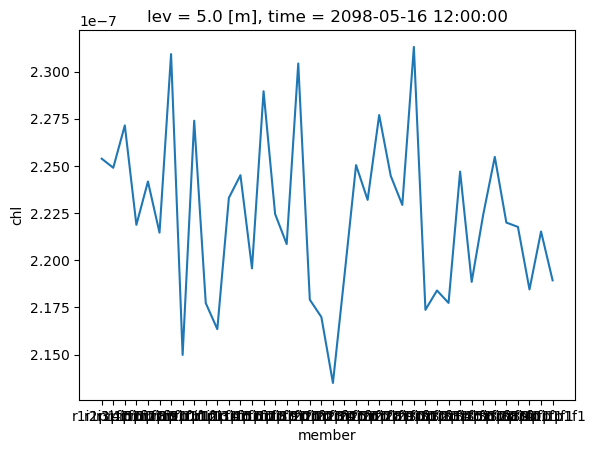

In [9]:
ds[load_config('job_config.yaml')['catalog_search_query_dict']['variable_id']].isel(time=1000).isel(lev=0).mean(dim=['i','j']).plot()

## utilise CMIP6 data catalogs for NCI holdings

##### Information on climate data catalogs across Australian HPC

**ACCESS-NRI** https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html <br>
**NCI** https://opus.nci.org.au/pages/viewpage.action?pageId=213713098


##### $\bigstar$ Get inspiration from ACCESS-NRI intake catalog docs: ACCESS-ESM1-5 CMIP6 example
https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html

## import packages

In [ ]:
import intake
import xarray as xr
import numpy as np
import gc
import json

### import the ACCESS-NRI catalog

In [ ]:
catalog = intake.cat.access_nri

### (1) "I know I want Australian CMIP6 data - so that's fs38 and I need access to that NCI project"

In [ ]:
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

### (2) "what are the realms covered by cmip6_fs38?"

In [ ]:
report_esm_unique(cmip6_fs38_datastore,keep_list=['realm'])

### (3) I want to see what variables, over what frequencies, are available in both the 'ocean' & 'oceanBgchem' realms

In [ ]:
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'])

In [ ]:
[sorted_unique_dict, table_data] = report_esm_unique(cmip6_fs38_ocean_datastore,return_results=True)

## what is the long name of a particular variable?

In [ ]:
var_name_info(cmip6_fs38_ocean_datastore,'intpp')

## filter catalog for final ACCESS-ESM1.5 dataset

In [ ]:
final_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='intpp',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [ ]:
report_esm_unique(final_search)

## what is the chunking of the files in this final_search catalog?

In [ ]:
final_search.df['path'].iloc[0]

In [ ]:
find_chunking_info(final_search,'intpp',return_results=False)

## load without specifying any chunking

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search)

In [ ]:
ds_ESM15_esorted

#### One still needs to know what dimensions (1, 300, 360 ; ) refers to and something about MB size per chunk to set the time to 220 . . . these rules of thumb should be in the yaml settings file until much more complicated heuristics could be coded

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_settings={'chunks':{'member':1,'time':220,'j':300,'i':360}})

In [ ]:
ds_ESM15_esorted

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_key='ACCESS_ESM15_2D')

In [ ]:
ds_ESM15_esorted

In [ ]:
ds_ESM15_esorted.isel(member=0).mean('time').intpp.plot()

## 3D dataset?

In [ ]:
thetao_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='thetao',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [ ]:
report_esm_unique(thetao_search)

In [ ]:
find_chunking_info(thetao_search,'thetao',return_results=False)

In [ ]:
find_chunking_info(thetao_search,'thetao',return_results=True)

In [ ]:
xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/thetao/gn/v20191203/thetao_Omon_ACCESS-ESM1-5_historical_r3i1p1f1_gn_189001-189912.nc')

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search)

In [ ]:
ds_ESM15_esorted

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search,chunking_key='ACCESS_ESM15_3D')

In [ ]:
ds_ESM15_esorted

# let's use the tools as they exist to try to start the workflow

## I want Australian CMIP6 data

In [ ]:
cmip6_fs38_datastore = load_cmip6_fs38_datastore()

In [ ]:
report_esm_unique(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']))

In [ ]:
CSEPTA_intpp_catalog = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA'])

In [ ]:
CSEPTA_intpp_catalog

In [ ]:
show_methods(CSEPTA_intpp_catalog)

In [ ]:
report_esm_unique(CSEPTA_intpp_catalog)

In [ ]:
CSEPTA_intpp_catalog.unique()['path']

In [ ]:
search_dict = dict(experiment_id = 'historical',source_id = 'ACCESS-ESM1-5',variable_id = ['intpp'],realm = ['ocnBgchem'], frequency = 'mon',file_type='f')

In [ ]:
search = cmip6_fs38_datastore.search(**search_dict)
search

In [ ]:
search.unique()['path']

# let's repeat workflow with CLEX catalog

In [ ]:
cmip6_fs38_datastore = load_cmip6_CLEX_datastore()

In [ ]:
load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']

In [ ]:
report_esm_unique(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']))

In [ ]:
find_chunking_info(cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog']),'thetao',return_results=True)

In [ ]:
search = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog'])

In [ ]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(search,use_cftime=True,chunking_key='ACCESS_ESM15_3D')

In [ ]:
ds_ESM15_esorted

In [ ]:
data = ds_ESM15_esorted.isel({'lev':0,'member':0})
data

In [ ]:
data.mean(dim=['i','j']).thetao.plot()

### piControl

In [ ]:
search = cmip6_fs38_datastore.search(**load_config()['catalog_search_query_dict']['ACCESS_ESM15']['CSEPTA']['CLEX_catalog'])

In [ ]:
%%time
ds_ESM15 = load_ACCESS_ESM(search,use_cftime=True,chunking_key='ACCESS_ESM15_3D')

In [ ]:
ds_ESM15